In [1]:
#%matplotlib inline
# Loading python modules used in this notebook
#import pygments
#from pygments import highlight
#from pygments.lexers import MakefileLexer, CppLexer
#from pygments.formatters import HtmlFormatter
from IPython.core.display import display,HTML
import sqlite3
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.ticker import FormatStrFormatter
import os
import fileinput
import re
import subprocess
from displayNC import displayVariables,temperatureDisplay 


plt.style.use('seaborn-whitegrid')

    
def plot_dotty(param,perf,names,figname) :
    num_rows = len(names)
    fig, axes = plt.subplots(nrows = num_rows, ncols = 1, figsize = (10, num_rows * 2.5))
    cnt = 0
    formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
    for name,aH in zip(names, axes) :
        plt.sca(aH)
        lH, = plt.plot(param[:,cnt],perf,'b.',markersize = 1)
        aH.set_xlabel(name)
        #print name
        #plt.xlim = (-100000,-70000)  #This is hardcoded and is horrible. Will eventually fail
        aH.yaxis.set_major_formatter(formatter)
        aH.xaxis.set_major_formatter(formatter)
        aH.locator_params(axis='y',tight=True,nbins=6)
        cnt = cnt + 1
    fig.tight_layout()
    plt.savefig(figname)
    plt.close()

# Setup of the GOTM/FABM model for Langtjern

## Compiling GOTM and FABM

Please follow the instructions at <https://github.com/gotm-model/code>. Please note that the provided instructions are only available for Linux systems at present. 

For Windows, a combination of Visual Studio, CMake and the Intel Fortran compiler should work with minimal modifications when CMake is setup to generate Visual Studio project files.

For the rest of this document, it is assumed that Linux is used in combination with CMake, using GCC-5.4. 

### Getting the source code

Credentials might be required for repositories. The text highlighted in a box should be run in a shell.

#### GOTM

Clone the source code to a directory of your choice.
<section>
   <div class="warn">
   git clone https://github.com/gotm-model/code.git
   <div/>
</section>

Switch to lake branch.
<section>
   <div class="warn">
   git checkout lake
   <div/>
</section>

#### FABM
Clone the source code to a directory of your choice.
<section>
   <div class="warn">
   git clone git@gitlab.au.dk:anbios/fabm-prognos.git
   <div/>
</section>

#### Langtjern setup
Clone the source code to a directory of your choice.
<section>
   <div class="warn">
   git clone git@gitlab.au.dh:anbios/PROGNOS.git
   <div/>
</section>

### Compiling

#### FABM

From within FABM source directory.

Out-of-source builds should be preferred. Neater.
Create a _./build_ directory in the root folder for FABM (or wherever you like but point to the right _/src_ folder in the _cmake_ command below:

<section>
   <div class="warn">
   mkdir build <br>
   cd build <br>
   cmake ../src -DFABM_HOST=gotm <br>
   make <br>
   make install
   <div/>
</section>

Note that make will create libfabm.a in the _.build_ directory. _make install_ will place the library and some other include files in the _~/local_ directory. The later is convenient to have all the builds for both FABM and GOTM in a single directory (that can be added to the PATH) thus simplifying linking.

#### GOTM

From within GOTM source directory.

Repeating the comments for the FABM compilation. Create a _./build_ directory in the root folder for GOTM. You will need to point _cmake_ to FABM root dir. Modify the cmake command below to point the the right locations if necessary:

<section>
   <div class="warn">
   mkdir build <br>
   cd build <br>
   cmake ../src -DFABM_BASE=../../fabm-gotm <br>
   make <br>
   make install
   <div/>
</section>

### Running GOTM from the "PROGNOS/Langtjern" folder.


GOTM and FABM can take a variety of inputs, depending on data availability. The format required is described in the [FABM repository](https://github.com/fabm-model/fabm/wiki/GOTM). In short, model setup relies on three different types of files:

1. **.xml** General setup file. The different settings in _.nml_ files (see next item) will be read from the _langtjern.xml_ file inside the "_Langtjern_" folder.
1. **.nml** (nameless) files, to regulate the interaction between FABM and GOTM. And also to specify processes to be used within GOTM.
2. **.yaml** to specify which biogeochemical models will be used and their parameterizations.
3. **.dat** data files used to force and evaluate the model. They are in the format specified in the above link. Their are two basic flavors of data files: depth-dependent or independent.

In order to start running simulations with GOTM and FABM, some basic setup needs to be peformed first.

From the "_Langtjern_" folder in the PROGNOS repository, _editscenario.sh_ &mdash;a wrapper to a python script&mdash; needs to be run. This basically creates the <i>gotm_fabm.nml</i> and other nameless files in the "_Langtjern_" folder, filling with options read from the _Langtjern.xml_ file. 

<b>Important note:</b> The default option is NOT to use FABM when running GOTM. In order to change this *fabm_calc*  needs to be set to _.true._ in <i>gotm_fabm.nml</i>.

If you want to modify any setting there are two options:

1. Modify the _Langtjern.xml_ file and run _editscenario.sh_.
2. Modify the nameless files.

#### Setting up the meteo data

In order to run GOTM some basic meteo data are required. In this case, the file is called 
<i>meteo_file.dat</i> and should be located inside the _Langtjern_ folder. When instantiated through _editscenario.sh_ this file while be a copy of the file specified in  _langtjern.xml_. The file telling GOTM where the meteo data are located is _airsea.nml_.

In our particular setup, the meteo file was generated by running a [Python jupyter notebook](http://nbviewer.jupyter.org/github/Lecheps/PROGNOS_data/blob/master/PROGNOS_preprocessing.ipynb) that loads data from [AquaMonitor](http://www.aquamonitor.no/Portal/) and puts in in the format required by GOTM/FABM.

#### Running GOTM

The _Langtjern.xml_ file was modified to point to file generated by the Jupyter notebook that processes the AquaMonitor data.

After running "./editscenario.sh" the meteo data should be in place and GOTM should run.

<section>
   <div class="warn">
   ./gotm
   <div/>
</section>


### Calibrating GOTM

*ACPY*, a python package developped by B&B should be installed first with the provided wheel file.

Once ACPY is installed and on the path, it should be run from the ACPY folder in the Langtjern folder. 

<section>
   <div class="warn">
   acpy run config_acpy.xml
   <div/>
</section>

A _temp.obs_ file containing the meteo data should be present in the ACPY folder. Note that the format is slightly different than the one required by FABM/GOTM.


#### Results
All the parameters tested during the calibration are saved in a sqlite database, whose name is specified in <i>config_acpy.xml</i>. Let's visualize the results of the calibration.

In [2]:
basePath  = '/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/acpy/'
configFile = 'config_acpy.xml'

#Getting name of database from config_acpy.xml
tree = ET.parse(basePath + configFile)
root = tree.getroot()
p = tree.find("transports")
db_element = p.find("transport")
db_element = db_element.attrib
db_path = basePath + db_element["path"]

#Getting parameter names from config_acpy.xml
p = tree.find("parameters")
cnt = 0
variable_list = []
for i in p :
    cnt += 1
    dummy = i.attrib
    if 'variable' in dummy :
        variable_list.append(dummy["variable"])
    else :
        variable_list.append("dummy")
        
print("The variables being calibrated are: ", variable_list)

The variables being calibrated are:  ['shf_factor', 'swr_factor', 'wind_factor', 'k_min', 'A', 'g1', 'g2', 'dummy']


In [3]:

#Open database connection
conn = sqlite3.connect(db_path)
c = conn.cursor()
#Getting the "best" parameter set according to the log-likelihood
c.execute("SELECT parameters,lnlikelihood FROM results ORDER BY lnlikelihood DESC LIMIT 1")
params = c.fetchone()
log_like = float(params[1])
params = [float (x) for x in params[0].split(';')]


print("The best performing parameters are: ")
for a,b in zip(variable_list,params) :
    print (a, "\t->\t ", b)
print("With log-likelihood -> ", log_like)

The best performing parameters are: 
shf_factor 	->	  0.5302477055599399
swr_factor 	->	  0.6158811519591302
wind_factor 	->	  0.512842118072998
k_min 	->	  3.404851709407847e-08
A 	->	  0.862259248426251
g1 	->	  0.5928981709098142
g2 	->	  4.791058709983259
dummy 	->	  0.2785741792758936
With log-likelihood ->  -70912.42585973894


In [4]:
#Dotty plots simulation performed during calibration
#Storing the parameters as a numpy array
c.execute("SELECT parameters,lnlikelihood FROM results ORDER BY lnlikelihood DESC");
dotty_data = c.fetchall()
param_array = np.zeros((len(dotty_data), len(params)))
perf_array = np.zeros((len(dotty_data)))
cnt = 0
for i in dotty_data :
    param_array[cnt][:] = np.fromstring(i[0],sep=';')
    perf_array[cnt] = float(i[1])
    cnt = cnt + 1
    
num_dots = int(len(perf_array)*0.05)    
plot_dotty(param_array[:num_dots,:],perf_array[:num_dots],variable_list,"dotty.jpg")
del param_array, perf_array
conn.close()

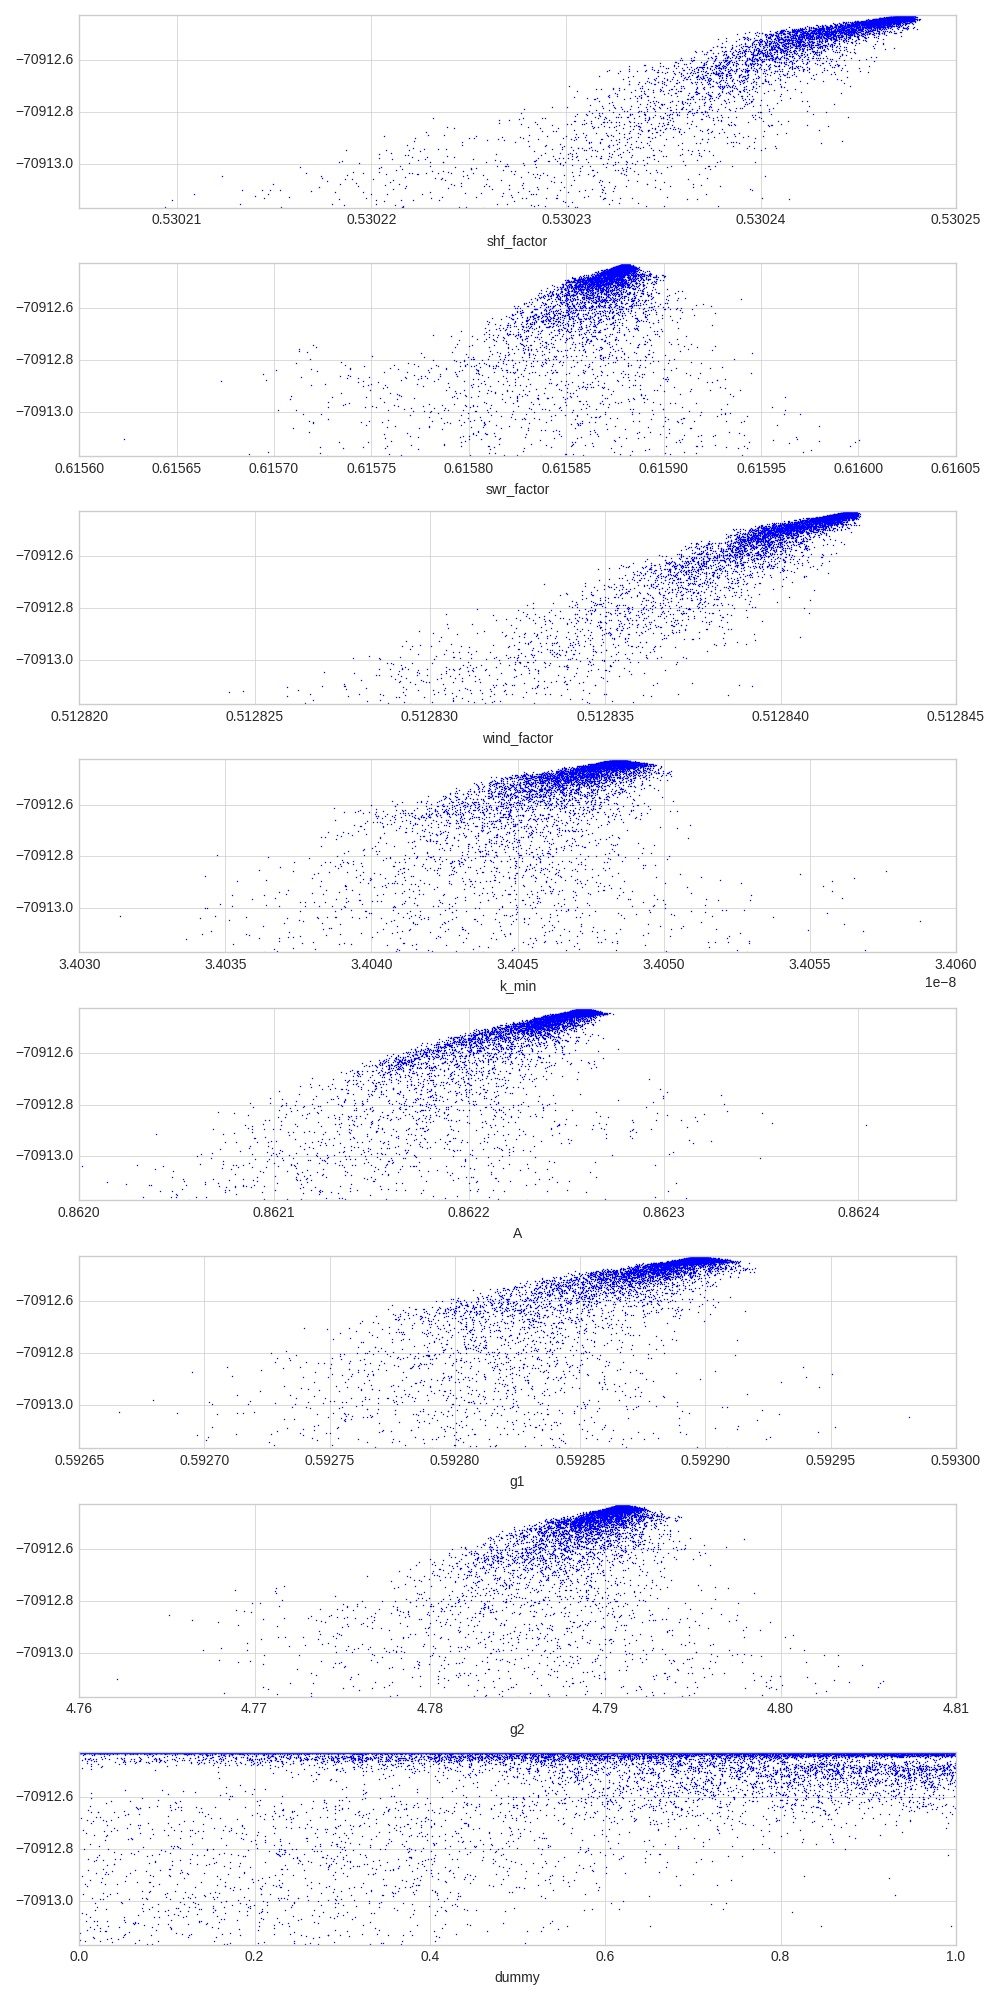

In [5]:
Image(filename='dotty.jpg') 

#### Running GOTM/FABM with the best performing parameter set

First, let's set parameter values in the respective nameless files. This can be read from <i>config_acpy.xml</i>.

In [6]:
#Loading parameter file information from config_acpy.xml   
tree = ET.parse(basePath + configFile)
root = tree.getroot()
p = tree.find("parameters")
parentPath = os.path.realpath(os.path.join(basePath,'..'))

#Replacing paramters in file
#This is laughingly inefficient but should do for smallish nml files
print("Setting parameter value in file:")
for child, value in zip(p,params):
    db_element = child.attrib
    if 'dummy' not in db_element :
        #Going up one path
        filename = parentPath + '/' + db_element['file']
        print(filename)
        pattern = db_element['variable'] + '\s*=.*$'
        replacement = db_element['variable'] + ' = ' +  str(value) + ','
        cnt = 0
        f = fileinput.FileInput(filename, inplace=True, backup='.bak')
        for line in f :
            line = re.sub(pattern,replacement,line.rstrip())
            print(line)
        f.close()

Setting parameter value in file:
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/airsea.nml
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/airsea.nml
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/airsea.nml
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/gotmturb.nml
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/obs.nml
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/obs.nml
/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern/obs.nml


In [7]:
#And now running gotm
callStr = parentPath + '/' + 'gotm'
print(parentPath)
p = subprocess.Popen('./gotm', cwd = parentPath)
p.wait()


/home/jose-luis/Dropbox/NIVA/PROGNOS_Development/PROGNOS/langtjern


0

#### Evaluating results

Loading the observed data:


-9.04155 23.99


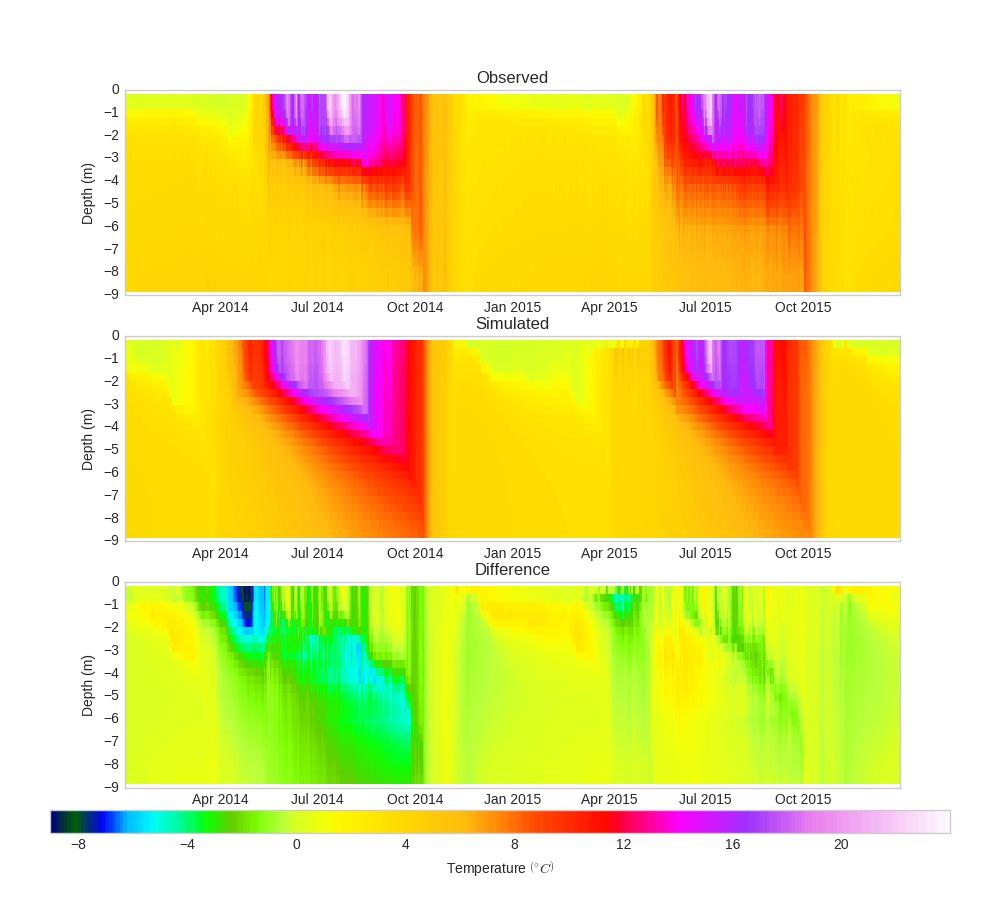

In [8]:
filename = parentPath + '/output.nc'
var_to_show = ['tprof','temp']
fig_name = "langtjern_temperatures.jpg"
temperatureDisplay(filename,fig_name)
Image(filename=fig_name) 

In [9]:
def css_styling():
    styles = open("./styles/custom.css", "r").read()
    return HTML(styles)
css_styling()

In [10]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>